In [1]:
import glob
import rioxarray as rio
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import xarray as xr
plt.style.use('aslak')
import joblib
import pyproj
from scipy.ndimage import gaussian_filter,uniform_filter

import rioxarray as rio
popgrid = rio.open_rasterio('pop2021.tif',band_as_variable=True).band_1

projtransform = pyproj.transformer.Transformer.from_crs(popgrid.rio.crs, 'epsg:4326', always_xy=True)


In [2]:
def get_local_population(clusterimage):
    x0 = np.unique(np.int64(clusterimage.x.values/1000))*1000+500
    y0 = np.unique(np.int64(clusterimage.y.values/1000))*1000+500
    return popgrid.sel(x=x0,y=y0)

def load_tile(tilename):
    ds = rio.open_rasterio(tilename)
    #Add some bands with local standard deviation:
    if False:
        gray = ds[1:3,:,:].mean(dim='band')
        gray.data = gaussian_filter(gray.data, sigma=1)
        ds=xr.concat(
            [
                ds,
                gray.expand_dims(band=[12]),
            ], dim='band',
        )    
    if False: #Add some bands with local deviation
        w = 3
        q = ds[1::3,:,:]
        #q.data = gaussian_filter(q.data**2, sigma=[0,w,w])-gaussian_filter(q.data, sigma=[0,w,w])**2
        #q.data = uniform_filter(q.data**2, size=[0,w,w])-uniform_filter(q.data, size=[0,w,w])**2
        q.data = uniform_filter(q.data*1.0, size=[0,w,w])
        ds = xr.concat(
            [
                ds,
                q.assign_coords(band = ds.band.values[-1] + np.arange(len(q.band)) + 1),
            ], dim='band',
        ) 
    return ds

def rgbplot(ds, satexponent = 0.7, brighten=0):
    rgb = np.sqrt(np.minimum(ds[3:0:-1,:,:]/3500,1))
    if (satexponent != 1) or (brighten != 0):
        hsv = colors.rgb_to_hsv(np.permute_dims(rgb.data,[1,2,0]))
        hsv[..., 2] = (hsv[..., 2] + brighten)/(1+ brighten)  # Brighten the image
        hsv[..., 1] = hsv[..., 1]**satexponent  # Increase saturation
        rgb.data = np.permute_dims(colors.hsv_to_rgb(hsv),[2,0,1])
        
    rgb.plot.imshow()
    plt.axis('off')
    plt.axis('equal')
    plt.title('')

def text_pop_numbers(localpop, fontsize=6):
    for r in range(localpop.shape[0]):
        for c in range(localpop.shape[1]):
            plt.text(localpop.x.values[c], localpop.y.values[r],
                f'{localpop.data[r,c]}', 
                ha='center', va='center', fontsize=fontsize, color='white')


In [ ]:


files=glob.glob('tiles/*.tif')
rawsamples = []
for file in tqdm.tqdm(files):
    Nskip=73 # better that it is not something divisible by the height
    ds = load_tile(file)
    data = np.reshape(ds.data,(len(ds.band),-1))[:,::Nskip].T
    rawsamples.append(data)
rawsamples = np.concatenate(rawsamples, axis=0)




  0%|          | 0/240 [00:00<?, ?it/s]

C:\Users\ag\AppData\Local\Temp\ipykernel_22932\990822859.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('nipy_spectral', clusterer.n_clusters)


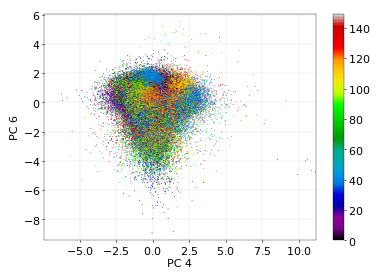

In [4]:
#DETERMINE 
from sklearn.decomposition import PCA,FastICA 
from sklearn.cluster import KMeans

def logtransform(samples,offset=150):
    samples = samples.copy()
    samples[:,-3]=samples[:,-3]*100 #nightlight band is a different scale
    samples[:,0:-2] = np.log(samples[:,0:-2] + offset) #two last bands are not transformed
    return samples

if True:
    logoffset = 150 #~150 is the 1st percentile
    logsamples = logtransform(rawsamples, offset=logoffset)
    #transformer = PCA(whiten=True).fit(logsamples)
    transformer = FastICA().fit(logsamples)
    projected_samples = transformer.transform(logsamples)
    
    clusterer = KMeans(n_clusters=150).fit(projected_samples) #70

    cmap = cm.get_cmap('nipy_spectral', clusterer.n_clusters)

    plt.figure(dpi=100)
    pcs=[4,6]
    plt.scatter(projected_samples[:,pcs[0]-1], projected_samples[:,pcs[1]-1],c = clusterer.predict(projected_samples), s=0.1, cmap=cmap)
    plt.xlabel(f'PC {pcs[0]:.0f}')
    plt.ylabel(f'PC {pcs[1]:.0f}')
    plt.axis('equal')
    plt.colorbar()

    clusterspecification = {'logoffset': logoffset, 'transformer': transformer, 
                            'clusterer': clusterer, 'clustercmap': cmap}
    joblib.dump(clusterspecification, 'clusterspecification.pkl')
    


In [5]:
rawsamples.shape

(194880, 14)

In [6]:
clusterspecification = joblib.load('clusterspecification.pkl')

def project_samples(rawsamples):
    return clusterspecification['transformer'].transform(logtransform(rawsamples,clusterspecification['logoffset']))

def predict_clusters(rawdata):
    isXarray = not isinstance(rawdata, np.ndarray)
    if isXarray:
        output = rawdata[0,:,:].squeeze()*0
        rawdata = rawdata.data
    sz = rawdata.shape
    clusters = clusterspecification['clusterer'].predict(
        project_samples(np.reshape(rawdata, (sz[0],-1)).T)
        )
    if isXarray:
        output.data = np.reshape(clusters, sz[1:])
        return output
    else:
        return np.reshape(clusters, sz[1:])




In [8]:
import pandas as pd

def get_frequencies(clusterimage):
    n_clusters = clusterspecification['clusterer'].n_clusters
    localpop = get_local_population(clusterimage)
    x,y = np.meshgrid(localpop.x.values, localpop.y.values)
    p = localpop.data.flatten()
    x = x.flatten()
    y = y.flatten()
    freq = np.empty((len(p), n_clusters))
    for cluster_id in range(n_clusters):
        c = (clusterimage == cluster_id)
        for r in range(len(p)):
            xix = np.where(np.int64(c.x.values/1000)==np.int64(x[r]/1000))[0]
            yix = np.where(np.int64(c.y.values/1000)==np.int64(y[r]/1000))[0]
            #xix = np.abs(c.x.values-x[r])<=500
            #yix = np.abs(c.y.values-y[r])<=500
            ii = np.ix_(yix,xix)
            freq[r, cluster_id] = np.mean(c.data[ii])#.sel(x=xix,y=yix).data)
    return pd.DataFrame.from_dict({'x':x,'y':y,'pop':p, **{
            f'F{i}':freq[:,i] for i in range(freq.shape[1])}})

#q= get_frequencies(clusters)


In [ ]:
files=glob.glob('tiles/*.tif')
clusterfreq = []
for file in tqdm.tqdm(files):
    ds = load_tile(file)
    clusters = predict_clusters(ds)
    clusterfreq.append(get_frequencies(clusters))

clusterfreq = pd.concat(clusterfreq)
clusterfreq.to_parquet('cluster_frequencies.parquet')

  0%|          | 0/240 [00:00<?, ?it/s]

In [ ]:
#clusterfreq.corr().style.background_gradient(cmap='coolwarm')

R2: 0.797
Coefficients: [    0     0    10     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0 13751
     0     0     0     0     0     0     0     0     0     0     0  8382
 72867     0     0  2952     0     0     0     0     0 63819     0     0
     0     0     0     0     0     0     0     0     0 39950     0     0
     0     0     0     0     0     0  9184     0     0     0     0     0
     0     0   458     0     0     0     0     0     0     0     0     0
     0     0  5737     0  5157     0     0     0     0     0     0     0
     0     0     0     0   328     0     0     0 11706     0     0     0
     0     0 21956     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0 25258     0     0     0
     0     0     0     0     0     0  7290     0     0     0    38     0
     0  1811     0     0     0     0]


C:\Users\ag\AppData\Local\Temp\ipykernel_21156\527685159.py:19: RuntimeWarning: divide by zero encountered in log
  m = np.median(Ypred[np.abs(np.log(Y)-np.log(xx))<np.log(2)])


['regression.pkl']

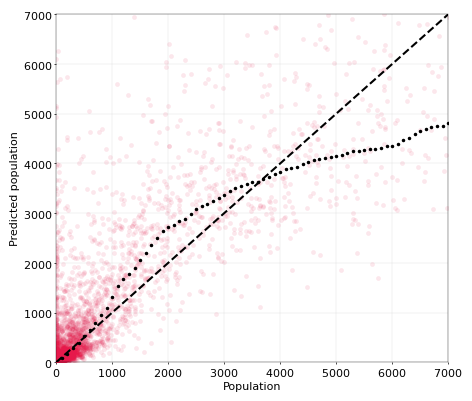

In [ ]:
clusterfreq = pd.read_parquet('cluster_frequencies.parquet')

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV

X= clusterfreq.loc[:,clusterfreq.columns.str.startswith('F')].values
Y= clusterfreq[['pop']].values.flatten()
X=X[Y>=0,:]
Y=Y[Y>=0]
reg = ElasticNetCV(positive=True, fit_intercept=False, l1_ratio=[.1, .5, .7, .9, .95, .99, 1]).fit(X, Y)
#reg = LinearRegression(fit_intercept=False,positive=True).fit(X, Y)
print(f'R2: {reg.score(X,Y):.3f}')
print(f'Coefficients: {np.int64(reg.coef_)}')
plt.figure(dpi=100, figsize=(4,4))
Ypred = reg.predict(X)
plt.scatter(Y, Ypred,alpha=0.1)

for xx in np.linspace(100,10000,100):
    m = np.median(Ypred[np.abs(np.log(Y)-np.log(xx))<np.log(2)])
    plt.plot(xx,m,'k.')
plt.xlim([0,7000])
plt.ylim([0,7000])
plt.plot([0,7000],[0,7000], color='black', linestyle='--')
plt.xlabel('Population')
plt.ylabel('Predicted population')
joblib.dump(reg, 'regression.pkl')


In [ ]:
def apply_model(rawimage,rescale=True):
    output = rawimage[0,:,:].squeeze()*0
    clusters = predict_clusters(rawimage)
    pixelarea = np.abs((rawimage.x[1]-rawimage.x[0])*(rawimage.y[1]-rawimage.y[0])).values/1e6 # pixel size km2
    for i in range(len(reg.coef_)):
        output.data = output.data + reg.coef_[i] * (clusters==i).data * pixelarea
    if rescale:
        lpop = get_local_population(rawimage)
        
        for c in range(lpop.shape[1]):
            ix = np.where(np.int64(output.x.values/1000)==np.int64(lpop.x.values[c]/1000))[0]
            for r in range(lpop.shape[0]):
                p = lpop.data[r,c]
                iy = np.where(np.int64(output.y.values/1000)==np.int64(lpop.y.values[r]/1000))[0]
                ii = np.ix_(iy,ix)
                totpop = np.sum(output.data[ii])
                if totpop > 0:
                    output.data[ii] = output.data[ii] * p / totpop
                #todo elif p>0 
    return output


In [ ]:
plt.figure(figsize=(6,5),dpi=600)
import nominatim
files = np.random.permutation(files)
N=4
cmap = 'inferno'
for ii,file in enumerate(files[0:N]):
    ds = load_tile(file)
    localpop = get_local_population(ds)
    
    lon,lat = projtransform.transform(np.mean(ds.x.values), np.mean(ds.y.values))
    details = nominatim.reverselookup(lat,lon,13)
    shortname = '\n'.join(list(details['address'].values())[0:2]) + ', ' + details['address']['country_code'].upper()
    
    #shortname = details['short_dislay_name'].replace(',','\n')
    plt.subplot2grid((3,N),(0,ii))
    rgbplot(ds)
    plt.title(shortname,fontsize=6)
    if ii==0:
        plt.ylabel('S2 RGB')
    
    plt.subplot2grid((3,N),(1,ii))
    rgbplot(ds,brighten=0.9,satexponent=7)
    popestimate = apply_model(ds,rescale=True)
    popestimate.plot.imshow(add_colorbar=False,cmap=cmap,vmin=0,vmax=5,alpha=np.clip(popestimate.data,0,1))
    plt.axis('off')
    plt.axis('equal')
    plt.title('')
    if ii==0:
        plt.ylabel('pop per pixel')


    plt.subplot2grid((3,N),(2,ii))
    
    rgbplot(ds)
    popsmooth = popestimate.copy()
    pixels_per_km= 1/(.02*.02)
    popsmooth.data=gaussian_filter(popsmooth.data*pixels_per_km, sigma=3)
    popsmooth.data[popsmooth.data<100]=np.nan
    h = popsmooth.plot.imshow(add_colorbar=False,vmin=0,vmax=5*pixels_per_km,cmap=cmap)
    plt.axis('equal')
    text_pop_numbers(localpop,fontsize=4)
    plt.title('')
    if ii==0:
        plt.ylabel('pop per km2')

    print(details['display_name'][:10],f"https://maps.google.com/?ll={details['lat']},{details['lon']}&z=14")



plt.subplots_adjust(hspace=0.0, wspace=0)
plt.tight_layout()

plt.savefig('figures/population_estimates.png', dpi=600, bbox_inches='tight')


NameError: name 'plt' is not defined